# HTR system using CRNN

>CSC 8851\
>Final Project\
>Ana Costa, Srikar Pottabathula

### Import Statements

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print(f"Found {len(physical_devices)} GPU(s), memory growth enabled")
    except:
        print("Memory growth setting failed")
else:
    print("No GPU found, using CPU")

Mounted at /content/drive
Found 1 GPU(s), memory growth enabled


### Setting paths and loading text data

In [ ]:
IMAGES_DIR = "/content/drive/MyDrive/Colab Notebooks/CSC 8851/Final Project/images"
GT_FILE = "/content/drive/MyDrive/Colab Notebooks/CSC 8851/Final Project/gt_test.txt"
MODEL_DIR = "/content/drive/MyDrive/Colab Notebooks/CSC 8851/Final Project/saved_base_models"
Custom_TEST_DIR = "/content/drive/MyDrive/Colab Notebooks/CSC 8851/Final Project/personal_test_images"
BATCH_SIZE = 16
EPOCHS     = 30
LEARNING_RATE = 1e-3

# parse Ground Truth file
filenames, texts = [], []
with open(GT_FILE, 'r', encoding='utf-8') as f:
    for line in f:
        fname, txt = line.strip().split('\t')
        filenames.append(os.path.join(IMAGES_DIR, fname))
        texts.append(txt)

# collect unique characters
charset = set(char for txt in texts for char in txt)
# sort to have deterministic mapping
charset = sorted(charset)
# CTC 'blank' token will be appended at end of index list
char_to_num = {ch:i for i,ch in enumerate(charset)}
num_to_char = {i:ch for ch,i in char_to_num.items()}
BLANK_IDX = len(charset)  # for CTC blank
NUM_CLASSES = len(charset) + 1

print(f"Detected {len(filenames)} samples, charset size={len(charset)} (+blank).")

Detected 2915 samples, charset size=75 (+blank).


### Computing image height and max wdth

In [ ]:
# since all images share same height, read first to get H;
# then scan all for max width W
H = None
max_W = 0
for p in filenames:
    img = Image.open(p).convert('L')
    w,h = img.size
    if H is None:
        H = h
    if w > max_W:
        max_W = w
max_W = ((max_W + 3)//4)*4

print(f"Using image height={H}, padded max width={max_W}")

Using image height=128, padded max width=4348


### Preprocessing functions

In [ ]:
def preprocess_image(path):
    """Load image, pad to (H, max_W), normalize to [0,1]."""
    if isinstance(path, tf.Tensor):
        path = path.numpy().decode('utf-8')
    elif isinstance(txt, (bytes, bytearray)):
        path = path.decode('utf-8')
    else:
        path = str(path)

    img = Image.open(path).convert('L')
    arr = np.array(img, dtype=np.float32) / 255.0

    h, w = arr.shape
    pad_width = max_W - w
    if pad_width > 0:
        arr = np.pad(arr, ((0,0),(0,pad_width)), constant_values=1.0)
    else:
        arr = arr[:, :max_W]

    arr = arr[..., np.newaxis]
    return arr

def encode_label(txt):
    if isinstance(txt, tf.Tensor):
        s = txt.numpy().decode('utf-8')
    elif isinstance(txt, (bytes, bytearray)):
        s = txt.decode('utf-8')
    else:
        s = str(txt)

    # build the label array, skipping any unknown chars
    labels = []
    for c in s:
        if c in char_to_num:
            labels.append(char_to_num[c])
        else:
            continue

    return np.array(labels, dtype=np.int32)

def tf_preprocess(path, txt):
    # load image
    img = tf.py_function(preprocess_image, inp=[path], Tout=tf.float32)
    img.set_shape([H, max_W, 1])

    # encode label
    lbl = tf.py_function(encode_label, inp=[txt], Tout=tf.int32)
    lbl.set_shape([None])

    input_len = tf.cast(max_W // 4, tf.int32)
    label_len = tf.shape(lbl)[0]

    return {
      'img': img,
      'label': lbl,
      'input_len': input_len,
      'label_len': label_len
    }

### Split data for training, testing, and validation

In [ ]:
def make_dataset(paths, texts, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, texts))
    if shuffle:
        ds = ds.shuffle(len(paths))
    ds = ds.map(tf_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.padded_batch(BATCH_SIZE,
                         padded_shapes={
                             'img': [H, max_W, 1],
                             'label': [None],
                             'input_len': [],
                             'label_len': []
                         },
                         padding_values={
                             'img': 1.0,
                             'label': 0,
                             'input_len': 0,
                             'label_len': 0
                         })
    return ds.prefetch(tf.data.AUTOTUNE)

# train/test/val split: 81%/10%/9%
train_paths, test_paths, train_texts, test_texts = train_test_split(
    filenames, texts, test_size=0.10, random_state=35, shuffle=True)
train_paths, val_paths, train_texts, val_texts = train_test_split(
    train_paths, train_texts, test_size=0.10, random_state=35, shuffle=True)

train_ds = make_dataset(train_paths, train_texts, shuffle=True)
val_ds   = make_dataset(val_paths,   val_texts,   shuffle=False)
test_ds  = make_dataset(test_paths,  test_texts,  shuffle=False)

print(f"Train/Val/Test sizes: {len(train_paths)}/{len(val_paths)}/{len(test_paths)}")

Train/Val/Test sizes: 2360/263/292


### Predict Function

In [ ]:
def predict_image(model, img_path):
    """Run model on single image and decode with greedy CTC."""
    arr = preprocess_image(img_path)
    arr = np.expand_dims(arr, 0)
    y_pred = model.predict(arr, verbose=0)

    input_len = np.array([max_W//4], dtype=np.int32)
    decoded = tf.keras.backend.ctc_decode(
        y_pred, input_length=input_len, greedy=True
    )[0][0].numpy()

    # map to chars, skip blanks
    chars = []
    for idx in decoded[0]:
        if idx < 0 or idx == BLANK_IDX:
            continue
        chars.append(num_to_char[idx])
    pred = ''.join(chars)
    pred_text = pred.replace("tf.Tensor(b'", "").replace("', shape(), dtypestring)", "")

    return pred_text

# Example usage:
# print(predict_image(model, 'images/c04-134-03.jpg'))

### Evaluation Metrics

In [ ]:
def levenshtein(a, b):
    """Classic Wagner–Fischer DP; works on lists or strings."""
    # if you pass strings, it will iterate chars; if you pass lists, elements
    n, m = len(a), len(b)
    if n == 0: return m
    if m == 0: return n
    # create distance matrix
    dp = [[0]*(m+1) for _ in range(n+1)]
    for i in range(n+1): dp[i][0] = i
    for j in range(m+1): dp[0][j] = j
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = 0 if a[i-1] == b[j-1] else 1
            dp[i][j] = min(
                dp[i-1][j] + 1,      # deletion
                dp[i][j-1] + 1,      # insertion
                dp[i-1][j-1] + cost  # substitution
            )
    return dp[n][m]

def cer(ref, hyp):
    """Character Error Rate = edit distance over characters, normalized by len(ref)."""
    ref_chars = list(ref)
    hyp_chars = list(hyp)
    if len(ref_chars) == 0:
        return float(len(hyp_chars))
    return levenshtein(ref_chars, hyp_chars) / len(ref_chars)

def wer(ref, hyp):
    """Word Error Rate = edit distance over words, normalized by number of words in ref."""
    ref_words = ref.split()
    hyp_words = hyp.split()
    if len(ref_words) == 0:
        return float(len(hyp_words))
    return levenshtein(ref_words, hyp_words) / len(ref_words)

### Training and Validation step functions

In [ ]:
@tf.function
def train_step(batch):
    imgs = batch['img']
    labels = batch['label']
    input_len = tf.fill([tf.shape(imgs)[0]], tf.cast(max_W//4, tf.int32))
    label_len = batch['label_len']

    # **CRUCIAL**: expand dims so they become (batch,1)
    input_len  = tf.expand_dims(input_len, axis=1)
    label_len  = tf.expand_dims(label_len, axis=1)

    with tf.GradientTape() as tape:
        y_pred = model(imgs, training=True)  # (batch, T, num_classes)
        # compute CTC loss (per-batch)
        loss = tf.reduce_mean(
            tf.keras.backend.ctc_batch_cost(labels, y_pred, input_len, label_len)
        )
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

@tf.function
def val_step(batch):
    imgs = batch['img']
    labels = batch['label']
    input_len = tf.fill([tf.shape(imgs)[0]], tf.cast(max_W//4, tf.int32))
    label_len = batch['label_len']

    # **CRUCIAL**: expand dims so they become (batch,1)
    input_len  = tf.expand_dims(input_len, axis=1)
    label_len  = tf.expand_dims(label_len, axis=1)

    y_pred = model(imgs, training=False)
    loss = tf.reduce_mean(
        tf.keras.backend.ctc_batch_cost(labels, y_pred, input_len, label_len)
    )
    return loss

### Building the model (without Attention)

In [ ]:
def build_model():
    input_img = layers.Input(shape=(H, max_W, 1), name='img')

    # 5×Conv2D + pooling (height & width reduction by 4 total on width)
    x = input_img
    for i, (filt, pool) in enumerate(zip([16,32,64,128,128],
                                         [(2,2),(2,2),(2,1),(2,1),(2,1)])):
        x = layers.Conv2D(filt, (3,3), padding='same', activation='relu')(x)
        x = layers.MaxPooling2D(pool)(x)
    # at this point: x.shape = (batch, H/32, max_W/4, 128)

    # collapse height and channel dims into features
    shape = x.shape
    # Permute to (batch, time_steps, features)
    # time_steps corresponds to width axis
    x = layers.Permute((2,1,3))(x)  # now: (batch, W', H', C)
    x = layers.Reshape((shape[2], shape[1]*shape[3]))(x)  # (batch, W', H'*C)

    # 2×Bidirectional LSTM
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)

    # output layer
    y_pred = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    return Model(inputs=input_img, outputs=y_pred)

temp_model = build_model()
temp_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 128, 4348, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 4348, 16)  │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 2174, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 2174, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 1087, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 1087, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 1087, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 1087, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 1087, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 1087, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 1087, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute (Permute)               │ (None, 1087, 4, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1087, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1087, 512)      │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 1087, 512)      │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1087, 76)       │        38,988 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,433,548 (13.10 MB)

 Trainable params: 3,433,548 (13.10 MB)

 Non-trainable params: 0 (0.00 B)

### Custom Training loop with CTC loss

In [ ]:
# hyperparameters
EPOCHS = 20
LEARNING_RATE = 1e-3

# optimizer
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=EPOCHS,
    end_learning_rate=5e-4
)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
    clipnorm=1.0
)

# Build model
model = build_model()
model.compile(optimizer=optimizer)

# Training loop
# containers to track over epochs
cer_vals = []
wer_vals = []
train_losses = []
val_losses = []

for epoch in range(1, EPOCHS+1):
    # train
    total_loss = 0.0
    batches = 0
    for batch in train_ds:
        total_loss += train_step(batch)
        batches += 1
    train_loss = total_loss / batches

    # validate
    total_vloss = 0.0
    vbatches = 0
    for batch in val_ds:
        total_vloss += val_step(batch)
        vbatches += 1
    val_loss = total_vloss / vbatches

    train_losses.append(train_loss.numpy())
    val_losses.append(val_loss.numpy())
    print(f"Epoch {epoch}/{EPOCHS}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")

    # compute CER & WER on validation set
    total_cer = 0.0
    total_wer = 0.0
    for img_path, gt in zip(val_paths, val_texts):
        pred = predict_image(model, img_path)
        total_cer += cer(gt, pred)
        total_wer += wer(gt, pred)
    avg_cer = total_cer / len(val_paths)
    avg_wer = total_wer / len(val_paths)

    cer_vals.append(avg_cer)
    wer_vals.append(avg_wer)

    print(f"            val_CER={avg_cer:.4f}, val_WER={avg_wer:.4f}")

model_file = "model_04.keras"
model_path = os.path.join(MODEL_DIR, model_file)
model.save(model_path)

Epoch 1/20: train_loss=187.4537, val_loss=136.6168
           val_CER=1.0000, val_WER=1.0000
Epoch 2/20: train_loss=134.9639, val_loss=134.5904
           val_CER=0.9999, val_WER=1.0000
Epoch 3/20: train_loss=124.7113, val_loss=106.9034
           val_CER=0.8450, val_WER=0.9816
Epoch 4/20: train_loss=91.5998, val_loss=77.1555
           val_CER=0.5367, val_WER=0.8688
Epoch 5/20: train_loss=62.2739, val_loss=56.7482
           val_CER=0.3769, val_WER=0.7594
Epoch 6/20: train_loss=46.3814, val_loss=45.1861
           val_CER=0.3001, val_WER=0.6801
Epoch 7/20: train_loss=36.5467, val_loss=38.9573
           val_CER=0.2641, val_WER=0.6294
Epoch 8/20: train_loss=29.7771, val_loss=33.5522
           val_CER=0.2197, val_WER=0.5635
Epoch 9/20: train_loss=24.6069, val_loss=31.2112
           val_CER=0.2096, val_WER=0.5507
Epoch 10/20: train_loss=20.6157, val_loss=30.2988
           val_CER=0.1997, val_WER=0.5436
Epoch 11/20: train_loss=17.1900, val_loss=27.8409
           val_CER=0.1858, val_WE

In [ ]:
# Load model from saved models
# DO NOT EXECUTE THIS CODE BLOCK if you do not have a saved model
latest_model_file = "model_03.keras"
latest_model_path = os.path.join(MODEL_DIR, latest_model_file)

model = load_model(latest_model_path)

### Plotting Training and Validation losses

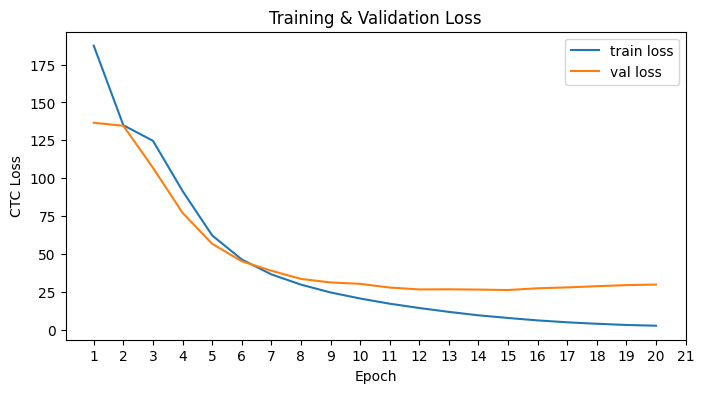

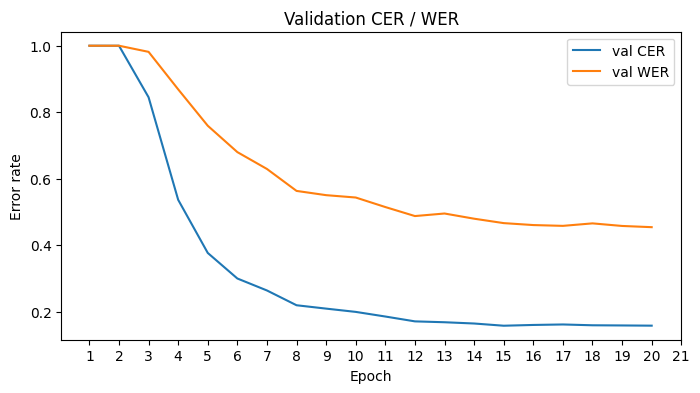

In [ ]:
# Training & Validation Loss graph
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses,   label='val loss')
plt.xlabel('Epoch')
plt.ylabel('CTC Loss')
plt.xticks(np.arange(0, 21, 1), np.arange(1, 22, 1))
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

# Validation CER / WER
plt.figure(figsize=(8,4))
plt.plot(cer_vals, label='val CER')
plt.plot(wer_vals, label='val WER')
plt.xlabel('Epoch')
plt.ylabel('Error rate')
plt.xticks(np.arange(0, 21, 1), np.arange(1, 22, 1))
plt.legend()
plt.title('Validation CER / WER')
plt.show()

### Inference and Prediction

In [ ]:
sample_img = filenames[175]
ground_truth = texts[175]
prediction = predict_image(model, sample_img)

print("GT:  ", ground_truth)
print("Pred:", prediction)
print("CER:", cer(ground_truth, prediction))
print("WER:", wer(ground_truth, prediction))

GT:   crushing our soul " ( see Hab. 2 , 10-11 ) . And it is
Pred: crushing our soul ( see Hab. 2 , 10-11 ) . And it is
CER: 0.037037037037037035
WER: 0.06666666666666667


In [ ]:
# Add your own images to the Custom_TEST_DIR folder listed above
# Then replace the file name in the below variable with your file name
test_img_name = "test_01.jpg"
test_img_path = os.path.join(Custom_TEST_DIR, test_img_name)
print("Pred:", predict_image(model, test_img_path))

Pred: This is the finst test sentence .
